In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
np.random.seed(42)
n_observations = 1000
t = np.arange(n_observations)

trend = 0.01 * t
seasonal = 11 * np.sin(2 * np.pi * t / 150)
noise = np.random.normal(0, 2, n_observations)

series = trend + seasonal + noise
data = pd.Series(series)

In [4]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

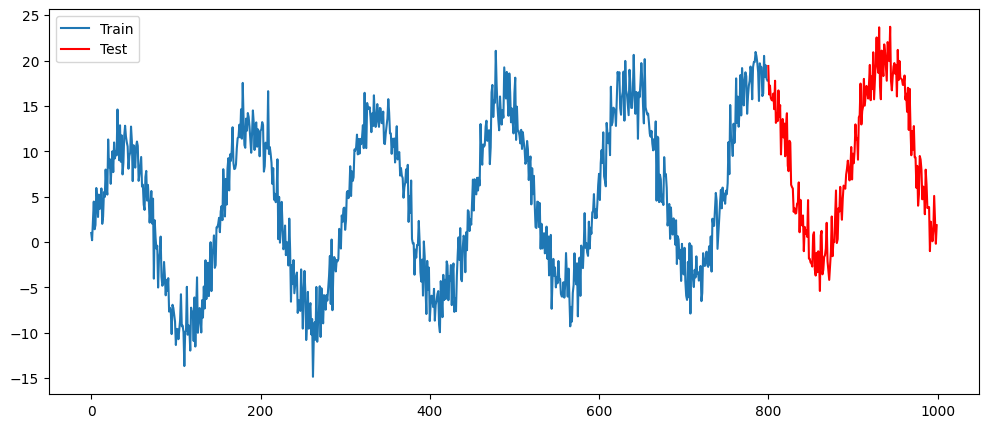

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="red")
plt.legend()
plt.show()

- Видим что ряд имеет четко выраженный восходящий тренд и циклическое повторение

In [6]:
model_ar = AutoReg(train, lags=150).fit()
pred_ar = model_ar.predict(
    start=len(train), end=len(train) + len(test) - 1, dynamic=False
)

In [7]:
model_ets = ExponentialSmoothing(
    train, trend="add", seasonal="add", seasonal_periods=150
).fit()
pred_ets = model_ets.forecast(len(test))

In [8]:
def calculate_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    return mae, rmse

In [9]:
mae_ar, rmse_ar = calculate_metrics(test, pred_ar)
mae_ets, rmse_ets = calculate_metrics(test, pred_ets)

In [10]:
results = pd.DataFrame(
    {
        "Metric": ["MAE", "RMSE"],
        "AR Model": [mae_ar, rmse_ar],
        "ETS Model": [mae_ets, rmse_ets],
    }
)
results

,Metric,AR Model,ETS Model
0,MAE,1.760749,1.675508
1,RMSE,2.204692,2.088876


Метрики: Чем ниже MAE и RMSE, тем точнее модель.

- MAE показывает среднюю абсолютную ошибку в тех же единицах, что и ряд.

- RMSE сильнее штрафует модель за крупные промахи

RMSE (2.08 – 2.20): Поскольку стандартное отклонение ($\sigma$) шума равно 2.0, идеальная модель (которая идеально разгадала тренд и синусоиду) не может получить RMSE ниже 2.0. Она всегда будет ошибаться на величину этого самого шума. Результат 2.08 у ETS говорит о том, что модель уловила структуру ряда почти на 100%.

MAE (1.67 – 1.76): результат 1.67 близок к теоретическому минимуму

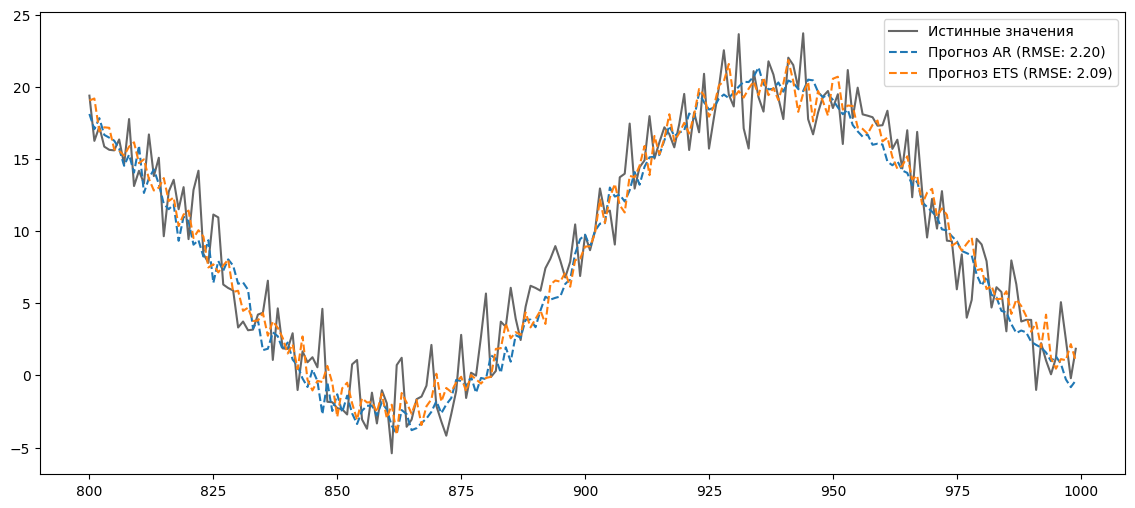

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, test, label="Истинные значения", alpha=0.6, color="black")
plt.plot(test.index, pred_ar, label=f"Прогноз AR (RMSE: {rmse_ar:.2f})", linestyle="--")
plt.plot(
    test.index, pred_ets, label=f"Прогноз ETS (RMSE: {rmse_ets:.2f})", linestyle="--"
)
plt.legend()
plt.show()

На графике видим:


- Точное попадание в фазу: Пунктирные линии идеально проходят через центры колебаний. Это значит, что параметры lags и seasonal_periods теперь точно соответствуют периоду 150.

- Отсутствие дрейфа: Прогнозы не улетают вверх или вниз и не сжимаются по амплитуде к концу периода (1000-й шаг). Модели поняли и силу тренда (0.01), и размах синусоиды (11).

- ETS vs AR: оранжевая линия (ETS) чуть точнее описывает плавность хода, чем синяя (AR). AR из-за большого количества лагов может подстраиваться под шум последних точек тренировочной выборки, что делает её чуть менее стабильной, чем ETS. ETS победила по обеим метрикам.